<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model_with_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streamlit Code

In [ ]:
!pip install streamlit
!pip install ddeint

2025-02-26 23:56:57.065 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.068 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.070 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.073 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.074 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-26 23:56:57.078 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

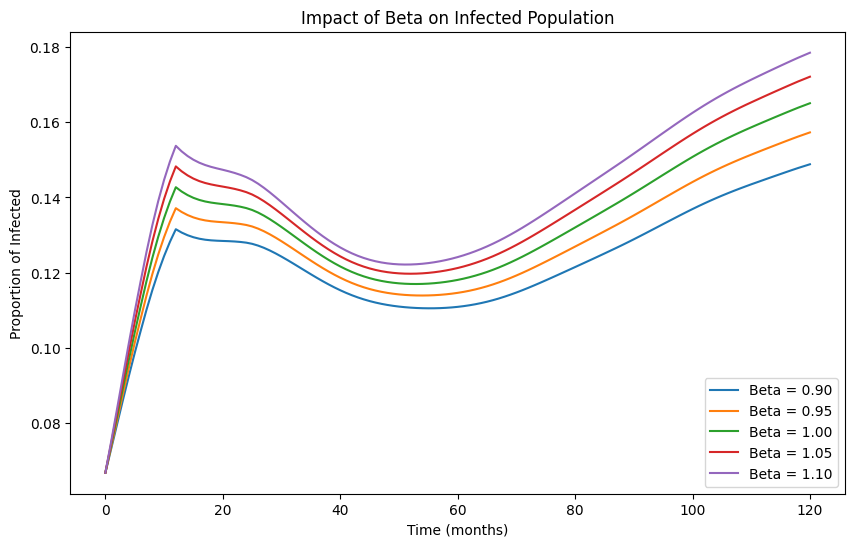

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from ddeint import ddeint
import pandas as pd
import streamlit as st

# ... (Your existing code for model definition, initial conditions, etc.)
# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006657  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12)  # Years to transition from youth to young adult
aging_rate_ya_to_a = 1 / (5 * 12)  # Years to transition from young adult to adult
tau_1, tau_2, tau_3 = 12, 6, 12  # Delays for infection, recovery, and relapse

# Seed for reproducibility
random.seed(42)
np.random.seed(42)

# Model definition
#def model(Y, t):
def model(Y, t, beta, gamma, rho):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
    else:
        S_y_delay = S_y
        I_y_delay = I_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
        I_ya_delay2 = Y(t - tau_2)[4]
        I_a_delay2 = Y(t - tau_2)[7]
    else:
        I_y_delay2 = I_y
        I_ya_delay2 = I_ya
        I_a_delay2 = I_a

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
        R_ya_delay3 = Y(t - tau_3)[5]
        R_a_delay3 = Y(t - tau_3)[8]
    else:
        R_y_delay3 = R_y
        R_ya_delay3 = R_ya
        R_a_delay3 = R_a

    t = int(t)

    # Population dynamics
    dS_y_dt = B - beta[t] * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta[t] * S_y * I_y_delay - (mu + gamma[t]) * I_y + rho[t] * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma[t] * I_y_delay2 - (mu + rho[t]) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta[t] * S_ya * I_y_delay - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta[t] * S_ya * I_y_delay - (mu + gamma[t]) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma[t] * I_ya_delay2 - (mu + rho[t]) * R_ya_delay3 - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta[t] * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta[t] * S_a * I_a - (mu + gamma[t]) * I_a_delay2
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma[t] * I_a_delay2 - (mu + rho[t]) * R_a_delay3

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions
def history(t):
    return [0.8000, 0.2000, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]





#########################################################################
# Streamlit app
st.title("Sensitivity Analysis Dashboard")

# Parameter selection (EC or Cigarettes)
product_type = st.selectbox("Product Type", ["EC", "Cigarettes"])

if product_type == 'EC':
    beta_0 = 0.18
    gamma_0 = (1.333 ** (1 / 12) - 1)
    rho_0 = (1.600 ** (1 / 12) - 1)
else:
    beta_0 = 0.003
    gamma_0 = (1.677 ** (1 / 12) - 1)
    rho_0 = (1.912 ** (1 / 12) - 1)

# Decay constants and seasonal variation (keep these as fixed parameters or add sliders if needed)
k_beta = 0.25
seasonal_amplitude = 0.005

# Parameter sliders with dynamic ranges
st.sidebar.subheader("Sensitivity Ranges")

beta_range = st.sidebar.slider("Beta Range (%)", 90, 110, (90, 110), 5)  # Default 90-110%
gamma_range = st.sidebar.slider("Gamma Range (%)", 90, 110, (90, 110), 5)
rho_range = st.sidebar.slider("Rho Range (%)", 90, 110, (90, 110), 5)

# Convert slider percentages to factors
beta_factors = np.linspace(beta_range[0] / 100, beta_range[1] / 100, 5)
gamma_factors = np.linspace(gamma_range[0] / 100, gamma_range[1] / 100, 5)
rho_factors = np.linspace(rho_range[0] / 100, rho_range[1] / 100, 5)


# ... (Your existing functions for beta_values_sensitivity, gamma_values_sensitivity, rho_values_sensitivity, linspace_integers)
# Functions to calculate parameters with sensitivity adjustment
def beta_values_sensitivity(t, factor=1.0):
    """Calculate beta values with sensitivity adjustment."""
    beta_base = beta_0 * np.exp(-k_beta * t / 12)  # Exponential decay
    beta_seasonal = seasonal_amplitude * np.cos(t / 12 * np.pi)  # Seasonal variation
    return factor * (beta_base + beta_seasonal)  # Adjust beta with sensitivity factor

def gamma_values_sensitivity(t, factor=1.0):
    """Calculate gamma values with sensitivity adjustment."""
    return factor * gamma_0

def rho_values_sensitivity(t, factor=1.0):
    """Calculate rho values with sensitivity adjustment."""
    return factor * rho_0

# Function to generate linearly spaced integers
def linspace_integers(start, stop, num):
    """Generate a linearly spaced array of integers."""
    step = (stop - start) // (num - 1)  # Calculate step using integer division
    return np.arange(start, stop + step, step, dtype=int)

####################################33


# Time points
t_range = linspace_integers(0, 1019, 1020)
t = np.linspace(0, 120, 120).astype('int32')


def run_sensitivity_analysis(parameter, factors):
    results = {}
    for factor in factors:
        beta = np.array([beta_values_sensitivity(t_i, factor if parameter == "Beta" else 1.0) for t_i in t_range])
        gamma = np.array([gamma_values_sensitivity(t_i, factor if parameter == "Gamma" else 1.0) for t_i in t_range])
        rho = np.array([rho_values_sensitivity(t_i, factor if parameter == "Rho" else 1.0) for t_i in t_range])

        sol = ddeint(model, history, t, fargs=(beta, gamma, rho))
        totals = sol.sum(axis=1)
        sol /= totals[:, None]
        results[factor] = sol
    return results

# Perform sensitivity analysis for selected parameters (you can select multiple)
selected_parameters = st.multiselect("Select Parameters for Analysis", ["Beta", "Gamma", "Rho"], default=["Beta"])

all_results = {}  # Store all results

for param in selected_parameters:
    factors = beta_factors if param == "Beta" else (gamma_factors if param == "Gamma" else rho_factors)
    all_results[param] = run_sensitivity_analysis(param, factors)



# Plotting with Streamlit
for param_name, results in all_results.items():
    st.subheader(f"Sensitivity Analysis - {param_name}")
    fig, ax = plt.subplots(figsize=(10, 6))

    for factor, sol in results.items():
        ax.plot(t, sol[:, 1], label=f"{param_name} = {factor:.2f}")  # Plot Infected compartment (I)

    ax.set_xlabel("Time (months)")
    ax.set_ylabel("Proportion of Infected")
    ax.set_title(f"Impact of {param_name} on Infected Population")
    ax.legend()
    st.pyplot(fig) # Display the plot in Streamlit